In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/severstal-steel-defect-detection/sample_submission.csv
/kaggle/input/severstal-steel-defect-detection/train.csv
/kaggle/input/severstal-steel-defect-detection/train_images/f1bd3a48a.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/55042415c.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/1dba99dc5.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/636700b91.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/e865201fb.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/cbb659739.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/1849f8952.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/e7a980a8f.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/50fb57a6c.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/2f8a16cc3.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/94a3786cb.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/

In [5]:
# library imports
import numpy as np 
import pandas as pd
import random as rn
import cv2 as cv 
import os
import sys
import skimage.io
from pathlib import Path

# neural network wizardry
import tensorflow as tf

# visuals
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

# paths
img_train_folder = Path('/kaggle/input/train_images/')
img_test_folder = Path('/kaggle/input/test_images/')


In [6]:
# imagine a 3*3 image with a diagional line across
X = np.eye(3,3, dtype=np.uint8)
Y = np.eye(3,3, dtype=np.uint8)

# we change one pixel
X[1,1] = 0

In [7]:
print(X)
print('')
print(Y)

[[1 0 0]
 [0 0 0]
 [0 0 1]]

[[1 0 0]
 [0 1 0]
 [0 0 1]]


In [8]:
def dice_coefficient(X, y):
    
    # convert the pixel/mask matrix to a one-dimensional series
    predicted = X.flatten()
    truth = y.flatten()
    
    # our masks will consist of ones and zeros
    # summing the result of their product gives us the cross section
    overlap = np.sum(predicted * truth)
    total_surface_area = np.sum(predicted + truth)
    
    # passing our calculated values to the formula
    return 2 * overlap / total_surface_area

In [9]:
print(f'The dice coefficient for 1 wrongly labeled pixel in a 3*3 image is: {dice_coefficient(X, Y)}')
print('(2 * 2 overlapping "1" pixels / 5 total "1" surface area)')

The dice coefficient for 1 wrongly labeled pixel in a 3*3 image is: 0.8
(2 * 2 overlapping "1" pixels / 5 total "1" surface area)


In [10]:
def mask_to_rle(mask):
    """
    params:  mask - numpy array
    returns: run-length encoding string (pairs of start & length of encoding)
    """
    
    # turn a n-dimensional array into a 1-dimensional series of pixels
    # for example:
    #     [[1. 1. 0.]
    #      [0. 0. 0.]   --> [1. 1. 0. 0. 0. 0. 1. 0. 0.]
    #      [1. 0. 0.]]
    flat = mask.flatten()
    
    # we find consecutive sequences by overlaying the mask
    # on a version of itself that is displaced by 1 pixel
    # for that, we add some padding before slicing
    padded = np.concatenate([[0], flat, [0]])
    
    # this returns the indeces where the sliced arrays differ
    runs = np.where(padded[1:] != padded[:-1])[0] 
    # indexes start at 0, pixel numbers start at 1
    runs += 1

    # every uneven element represents the start of a new sequence
    # every even element is where the run comes to a stop
    # subtract the former from the latter to get the length of the run
    runs[1::2] -= runs[0::2]
 
    # convert the array to a string
    return ' '.join(str(x) for x in runs)


In [11]:
rle_example = mask_to_rle(X)
print(f'The run-length encoding for our example would be: "{rle_example}"')

The run-length encoding for our example would be: "1 1 9 1"


In [12]:
def rle_to_mask(lre, shape=(1600,256)):
    '''
    params:  rle   - run-length encoding string (pairs of start & length of encoding)
             shape - (width,height) of numpy array to return 
    
    returns: numpy array with dimensions of shape parameter
    '''    
    # the incoming string is space-delimited
    runs = np.asarray([int(run) for run in lre.split(' ')])
    
    # we do the same operation with the even and uneven elements, but this time with addition
    runs[1::2] += runs[0::2]
    # pixel numbers start at 1, indexes start at 0
    runs -= 1
    
    # extract the starting and ending indeces at even and uneven intervals, respectively
    run_starts, run_ends = runs[0::2], runs[1::2]
    
    # build the mask
    h, w = shape
    mask = np.zeros(h*w, dtype=np.uint8)
    for start, end in zip(run_starts, run_ends):
        mask[start:end] = 1
    
    # transform the numpy array from flat to the original image shape
    return mask.reshape(shape)

In [13]:
print(f'The mask reconstructed from the run-length encoding ("{rle_example}") \
for our example would be:\n{rle_to_mask(rle_example, shape=(3,3))}')

The mask reconstructed from the run-length encoding ("1 1 9 1") for our example would be:
[[1 0 0]
 [0 0 0]
 [0 0 1]]


In [15]:
# reading in the training set
data = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')
data['ClassId'] = data['ClassId'].astype(np.uint8)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   uint8 
 2   EncodedPixels  7095 non-null   object
dtypes: object(2), uint8(1)
memory usage: 117.9+ KB


ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [16]:
# keep only the images with labels
squashed = data.dropna(subset=['EncodedPixels'], axis='rows', inplace=True)

# squash multiple rows per image into a list
squashed = (
    data[['ImageId', 'EncodedPixels', 'ClassId']]
        .groupby('ImageId', as_index=False) 
        .agg(list) 
)

# count the amount of class labels per image
squashed['DistinctDefectTypes'] = squashed['ClassId'].apply(lambda x: len(x))

# display first ten to show new structure
squashed.head(10)

ImageId                                      EncodedPixels ClassId  \
0  0002cc93b.jpg  [29102 12 29346 24 29602 24 29858 24 30114 24 ...     [1]   
1  0007a71bf.jpg  [18661 28 18863 82 19091 110 19347 110 19603 1...     [3]   
2  000a4bcdd.jpg  [37607 3 37858 8 38108 14 38359 20 38610 25 38...     [1]   
3  000f6bf48.jpg  [131973 1 132228 4 132483 6 132738 8 132993 11...     [4]   
4  0014fce06.jpg  [229501 11 229741 33 229981 55 230221 77 23046...     [3]   
5  0025bde0c.jpg  [8458 14 8707 35 8963 48 9219 71 9475 88 9731 ...  [3, 4]   
6  002af848d.jpg  [290800 6 291055 13 291311 15 291566 18 291822...     [4]   
7  002fc4e19.jpg  [146021 3 146275 10 146529 40 146783 46 147038...  [1, 2]   
8  0030401a5.jpg  [186833 1 187089 3 187344 6 187600 7 187855 10...     [4]   
9  0046839bd.jpg  [152926 1 153180 4 153434 6 153689 8 153943 11...     [3]   

   DistinctDefectTypes  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
5                    2  
6                    1  
7                    2  
8                    1  
9                    1

In [17]:

print(f"""The training set now consists of {len(squashed):,} distinct images,
for a total of {squashed["DistinctDefectTypes"].sum():,} labeled mask instances.""")

The training set now consists of 6,666 distinct images,
for a total of 7,095 labeled mask instances.


In [18]:
""" use a consistent color palette per label throughout the notebook """
import colorlover as cl

# see: https://plot.ly/ipython-notebooks/color-scales/
colors = cl.scales['4']['qual']['Set3']
labels = np.array(range(1,5))

# combining into a dictionary
palette = dict(zip(labels, np.array(cl.to_numeric(colors))))

In [19]:
# we want counts & frequency of the labels
classes = (
    data.groupby(by='ClassId', as_index=False)
        .agg({'ImageId':'count'})
        .rename(columns={'ImageId':'Count'})
)

classes['Frequency'] = round(classes['Count'] / classes['Count'].sum() * 100, 2) 
classes['Frequency'] = classes['Frequency'].astype(str) + '%'

# plotly for interactive graphs
fig = go.Figure(
    
    data=go.Bar(
        orientation='h',
        x=classes.Count,
        y=classes.ClassId,
        hovertext=classes.Frequency,
        text=classes.Count,
        textposition='auto',
        marker_color=colors),
    
    layout=go.Layout(
        title='Defect Type: Count & Frequency',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=400
    )
)

# display
fig.show()

In [20]:
# we want counts of the possible combinations of labels
permutations = pd.DataFrame(data=squashed.ClassId.astype(str).value_counts())

# and their frequency
permutations['Frequency'] = round(permutations['ClassId'] / permutations['ClassId'].sum() * 100, 2)
permutations['Frequency'] = permutations['Frequency'].astype(str) + '%'

# plotly for interactive graphs
fig = go.Figure(
    
    data=go.Bar(
        orientation='h',
        x=permutations.ClassId,
        y=permutations.index,
        hovertext=permutations.Frequency,
        text=permutations.ClassId,
        textposition='auto'),
    
    layout=go.Layout(
        title='Count of Distinct Defect Combinations in Images',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=500
    )
)

# display
fig.show()

In [21]:
def build_mask(encodings, labels):
    """ takes a pair of lists of encodings and labels, 
        and turns them into a 3d numpy array of shape (256, 1600, 4) 
    """
    
    # initialise an empty numpy array 
    mask = np.zeros((256,1600,4), dtype=np.uint8)
   
    # building the masks
    for rle, label in zip(encodings, labels):
        
        # classes are [1, 2, 3, 4], corresponding indeces are [0, 1, 2, 3]
        index = label - 1
        
        # fit the mask into the correct layer
        # note we need to transpose the matrix to account for 
        # numpy and openCV handling width and height in reverse order 
        mask[:,:,index] = rle_to_mask(rle).T
    
    return mask

In [22]:
def mask_to_contours(image, mask_layer, color):
    """ converts a mask to contours using OpenCV and draws it on the image
    """

    # https://docs.opencv.org/4.1.0/d4/d73/tutorial_py_contours_begin.html
    contours, hierarchy = cv.findContours(mask_layer, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    image = cv.drawContours(image, contours, -1, color, 2)
        
    return image

In [23]:
def visualise_mask(file_name, mask):
    """ open an image and draws clear masks, so we don't lose sight of the 
        interesting features hiding underneath 
    """
    
    # reading in the image
    image = cv.imread(f'{img_train_folder}/{file_name}')

    # going through the 4 layers in the last dimension 
    # of our mask with shape (256, 1600, 4)
    for index in range(mask.shape[-1]):
        
        # indeces are [0, 1, 2, 3], corresponding classes are [1, 2, 3, 4]
        label = index + 1
        
        # add the contours, layer per layer 
        image = mask_to_contours(image, mask[:,:,index], color=palette[label])   
        
    return image


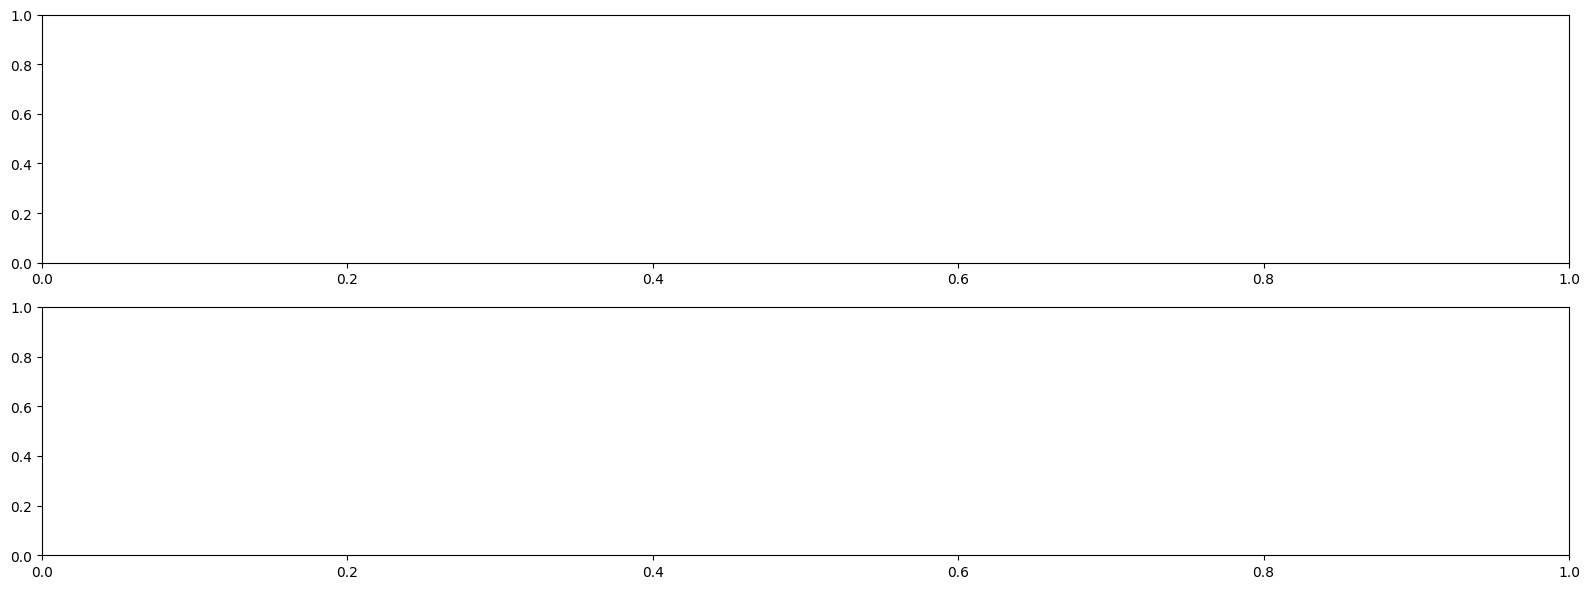

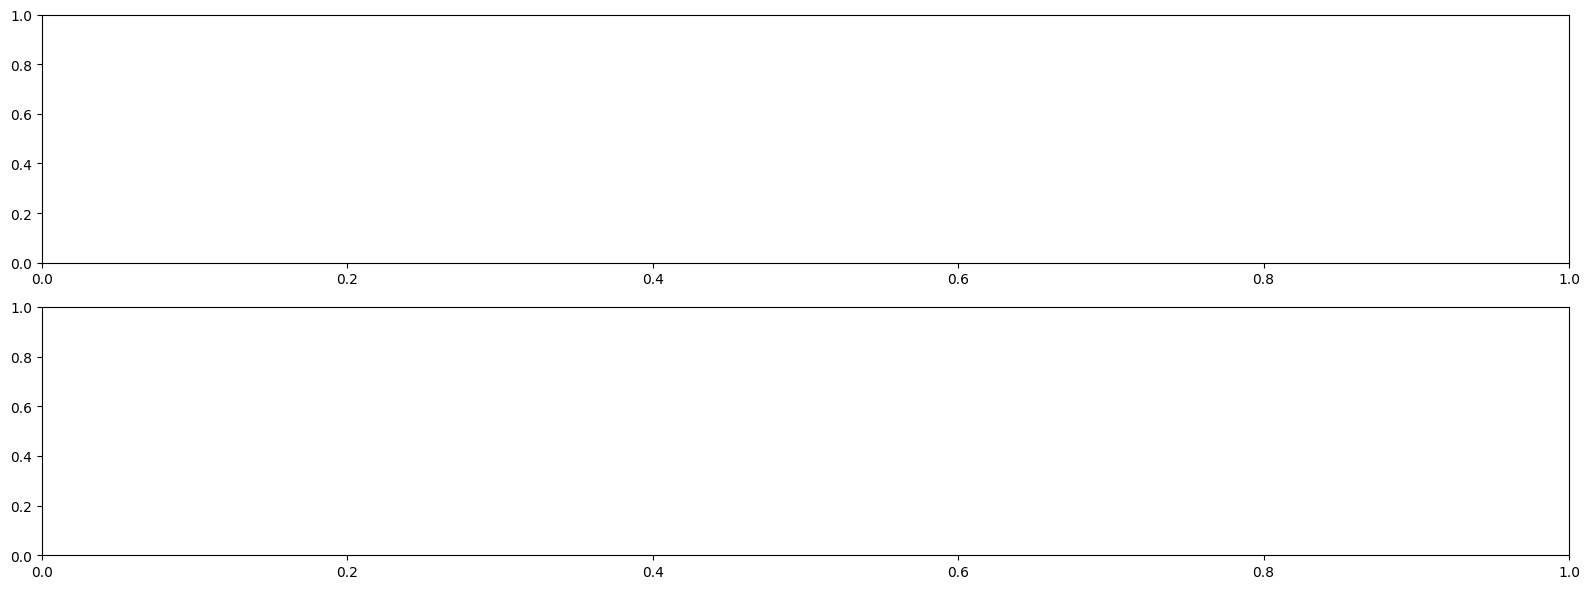

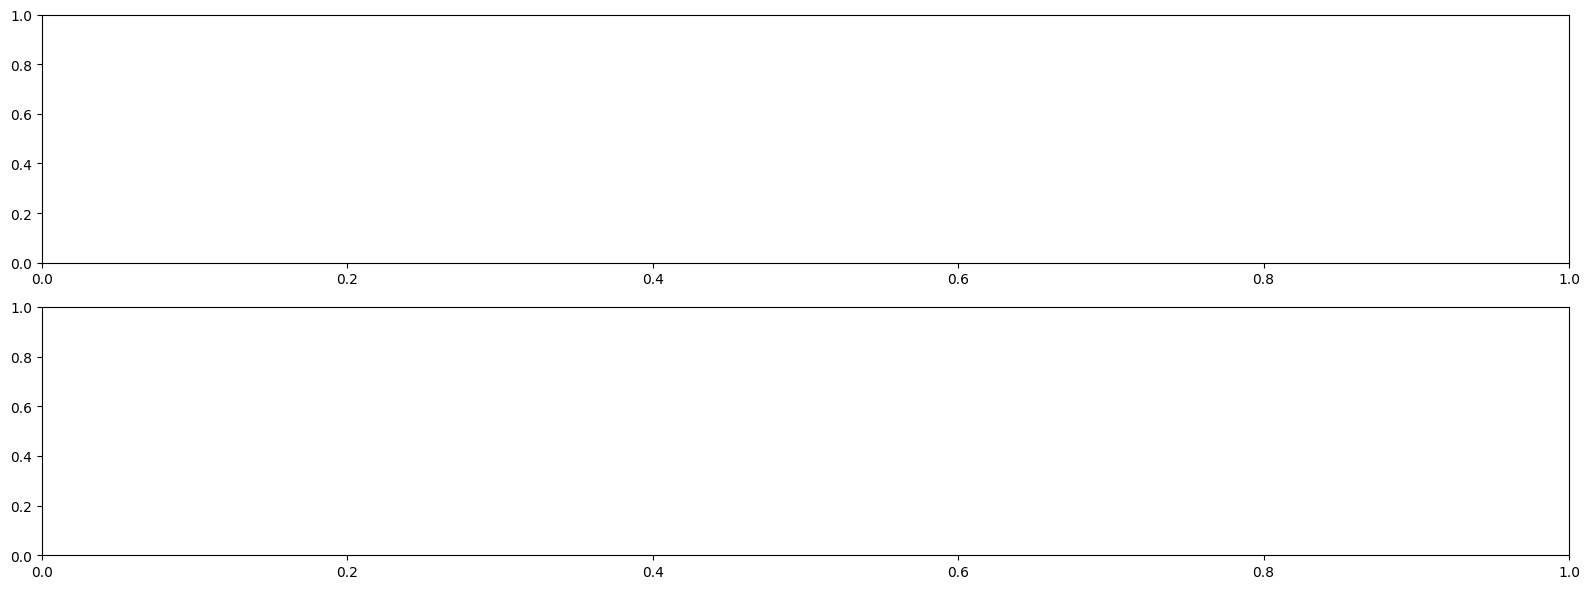

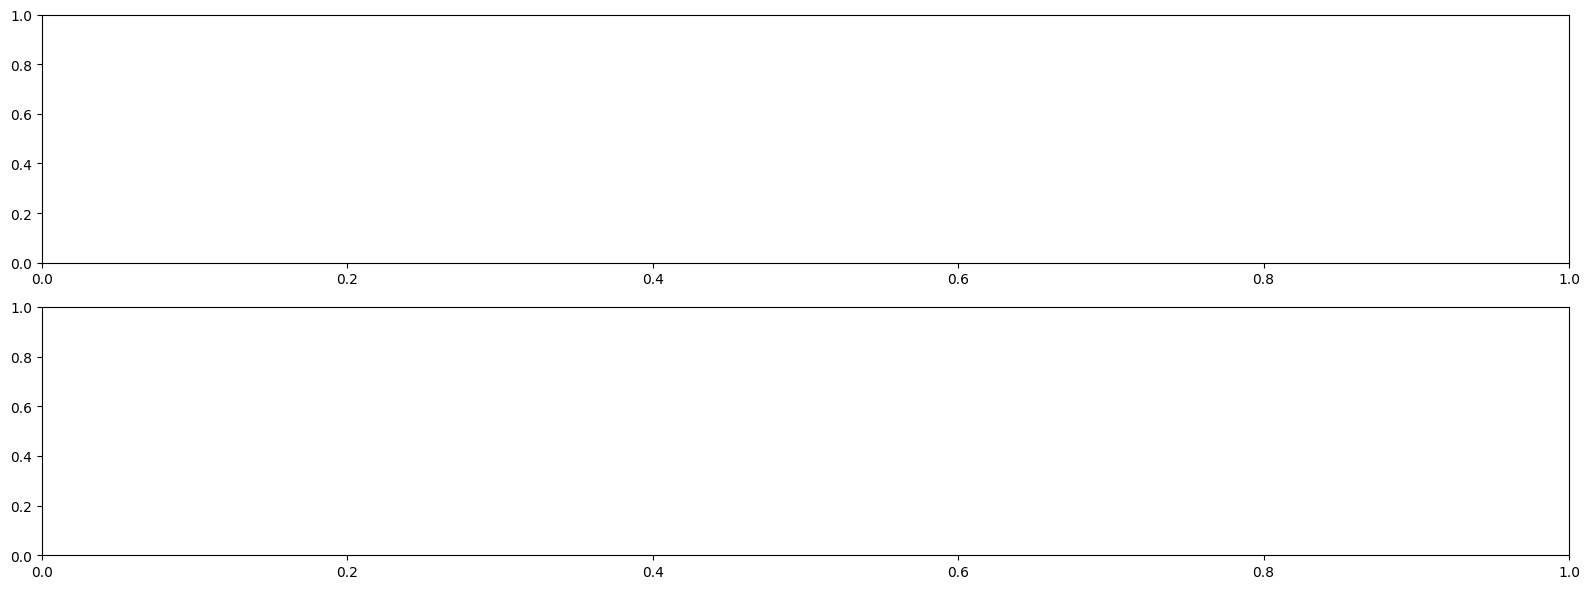

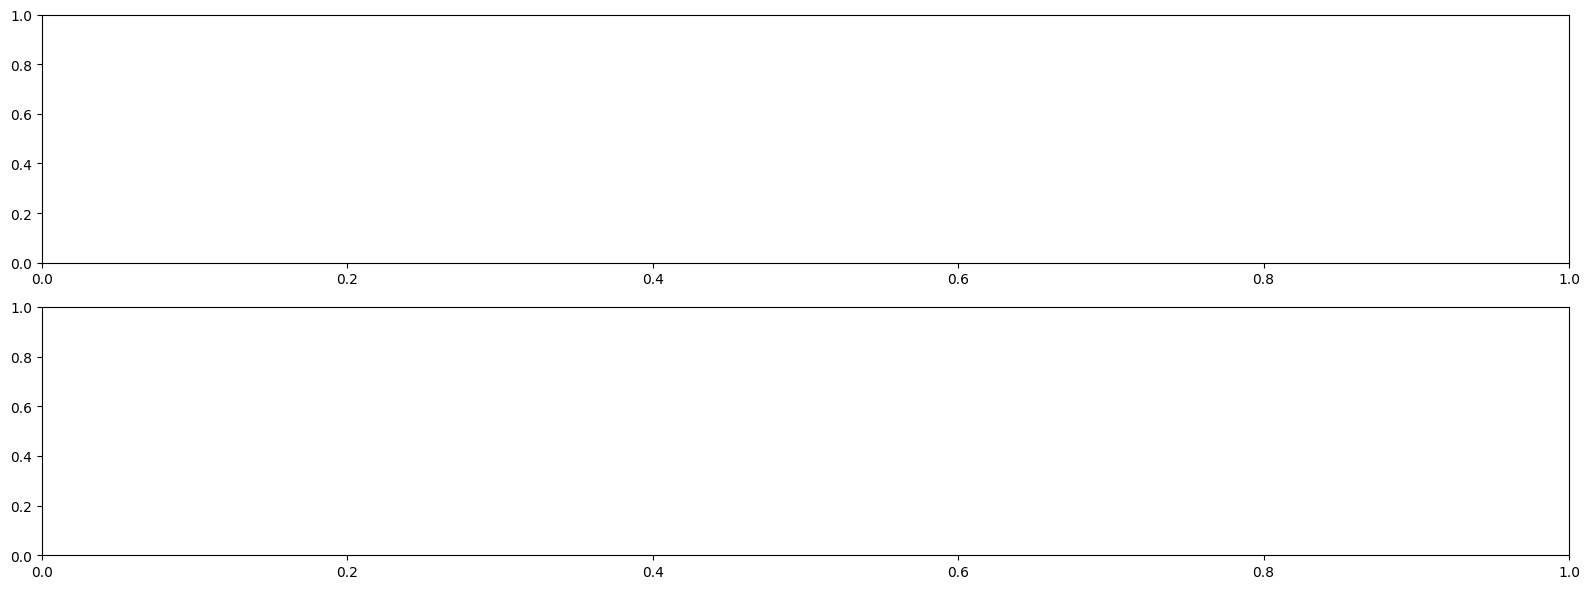

In [38]:

# the images we want to see
conditions = [
    squashed['ClassId'].astype(str)=='[1]',
    squashed['ClassId'].astype(str)=='[2]',
    squashed['ClassId'].astype(str)=='[3]',
    squashed['ClassId'].astype(str)=='[4]',
    squashed['DistinctDefectTypes']==2,
    squashed['DistinctDefectTypes']==3
]

# looping over the different combinations of labels 
for condition in conditions:
    
    # isolate from dataset and draw a sample
    sample = squashed[condition].sample(sample_size) 
    
    # make a subplot
    fig, axes = plt.subplots(sample_size, 1, figsize=(16, sample_size*3))
    fig.tight_layout()
    
    # looping over sample
    for i, (index, row) in enumerate(sample.iterrows()):
        
        # current ax
        ax = axes[i]
        
        # build the mask
        mask = build_mask(encodings=row.EncodedPixels, labels=row.ClassId)

        # fetch the image and draw the contours
        image = visualise_mask(file_name=row.ImageId, mask=mask)
        
        # check if image is not None
        if image is not None:
            # convert image to float and rescale pixel values to [0, 1]
            image = image.astype(np.float32) / 255.0
            
            # display
            ax.set_title(f'{row.ImageId}: {row.ClassId}')
            ax.axis('off')
            ax.imshow(image)
        
plt.show()
